In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True, 
    transform = ToTensor(),
)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True, 
    transform = ToTensor(),
)


In [3]:
batch_size = 64

train_dl = DataLoader(training_data, batch_size=batch_size)
test_dl = DataLoader(test_data, batch_size=batch_size)

In [4]:
from torchvision.utils import make_grid

64


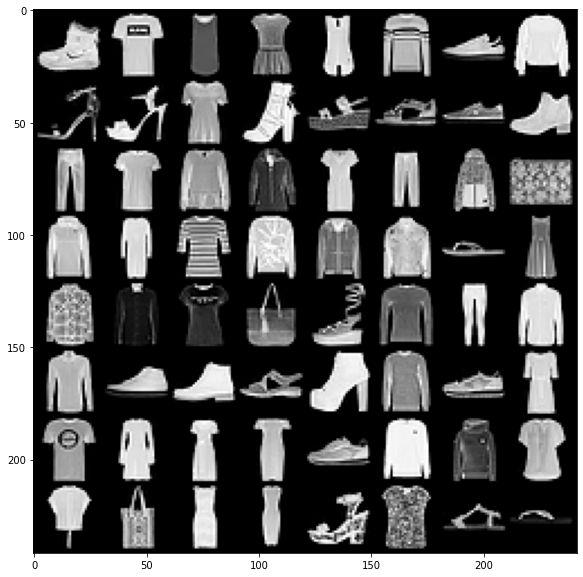

In [5]:
for image, label in train_dl:
#     print(image)
    plt.figure(figsize = (10, 10))
    plt.imshow(make_grid(image, nrow=8).permute(1, 2, 0))
#     print(label)
    print(len(image))
    break

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} Device')

Using cuda Device


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.ReLU()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
(28*28 + 2 - 3) / 1

783.0

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (image, label) in enumerate(dataloader):
        image, label = image.to(device), label.to(device)
        
        pred = model(image)
        loss = loss_fn(pred, label)
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(image)
            print(f"loss : {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += loss(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [13]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n" , "="*40)
    train(train_dl, model, loss, optimizer)
    test(test_dl, model, loss)
print('DONE')

Epoch 1
loss : 2.297028  [    0/60000]
loss : 1.315247  [ 6400/60000]
loss : 1.136930  [12800/60000]
loss : 1.592161  [19200/60000]
loss : 1.324049  [25600/60000]
loss : 1.040684  [32000/60000]
loss : 1.435516  [38400/60000]
loss : 1.277874  [44800/60000]
loss : 1.205366  [51200/60000]
loss : 1.617872  [57600/60000]
Test Error: 
 Accuracy: 52.3%, Avg loss: 1.291619 

Epoch 2
loss : 0.926193  [    0/60000]
loss : 1.077687  [ 6400/60000]
loss : 1.074973  [12800/60000]
loss : 1.437174  [19200/60000]
loss : 1.238499  [25600/60000]
loss : 0.987047  [32000/60000]
loss : 1.372700  [38400/60000]
loss : 1.202918  [44800/60000]
loss : 1.136790  [51200/60000]
loss : 1.547683  [57600/60000]
Test Error: 
 Accuracy: 53.0%, Avg loss: 1.261419 

Epoch 3
loss : 0.875579  [    0/60000]
loss : 1.042395  [ 6400/60000]
loss : 1.047896  [12800/60000]
loss : 1.440081  [19200/60000]
loss : 1.163583  [25600/60000]
loss : 0.981025  [32000/60000]
loss : 1.340647  [38400/60000]
loss : 1.160371  [44800/60000]
loss

In [14]:
def saveModel(model, filename='model'):
    torch.save(model.state_dict(), f'{filename}.pth')
    print('Saved')

In [15]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [20]:
for epoch in range(10):
    print(f"Epoch {epoch+1}\n" , "="*40)
    scheduler.step()
    train(train_dl, model, loss, optimizer)
    test(test_dl, model, loss)
print('Done')

Epoch 1
loss : 0.902168  [    0/60000]
D:\anaconda\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
loss : 0.993603  [ 6400/60000]
loss : 1.042720  [12800/60000]
loss : 1.344277  [19200/60000]
loss : 1.288352  [25600/60000]
loss : 1.001332  [32000/60000]
loss : 1.303071  [38400/60000]
loss : 1.063549  [44800/60000]
loss : 1.033854  [51200/60000]
loss : 1.424875  [57600/60000]
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.232083 

Epoch 2
loss : 0.780014  [    0/60000]
loss : 0.970247  [ 6400/60000]
loss : 1.

In [19]:
len(train_dl.dataset), len(train_dl)

(60000, 938)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (image, label) in enumerate(dataloader):
        image, label = image.to(device), label.to(device)
        
        pred = model(image)
        loss = loss_fn(pred, label)
        
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(image)
            print(f"loss : {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return (train_loss / len(dataloader)) 

In [22]:
def test(dataloader, model, loss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += loss(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [23]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [24]:
train_loss = []
test_loss = []
for epoch in range(10):
    print(f"Epoch {epoch+1}\n" , "="*40)
    train_loss.append(train(train_dl, model, loss, optimizer))
    test_loss.append(test(test_dl, model, loss))
print('DONE')

Epoch 1
loss : 0.756239  [    0/60000]
loss : 0.937525  [ 6400/60000]
loss : 0.988499  [12800/60000]
loss : 1.292888  [19200/60000]
loss : 1.154996  [25600/60000]
loss : 0.861480  [32000/60000]
loss : 1.330763  [38400/60000]
loss : 0.970752  [44800/60000]
loss : 0.946700  [51200/60000]
loss : 1.369805  [57600/60000]
Test Error: 
 Accuracy: 54.7%, Avg loss: 1.221277 

Epoch 2
loss : 0.794041  [    0/60000]
loss : 0.975667  [ 6400/60000]
loss : 0.996145  [12800/60000]
loss : 1.321950  [19200/60000]
loss : 1.128699  [25600/60000]
loss : 0.945484  [32000/60000]
loss : 1.304693  [38400/60000]
loss : 0.990005  [44800/60000]
loss : 0.966811  [51200/60000]
loss : 1.381263  [57600/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.223744 

Epoch 3
loss : 0.779081  [    0/60000]
loss : 0.952672  [ 6400/60000]
loss : 0.963770  [12800/60000]
loss : 1.308277  [19200/60000]
loss : 1.082141  [25600/60000]
loss : 0.893884  [32000/60000]
loss : 1.332587  [38400/60000]
loss : 0.974439  [44800/60000]
loss

In [31]:
def plotGraph(losses, title):
    plt.title(f'{title} Accuracy')
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

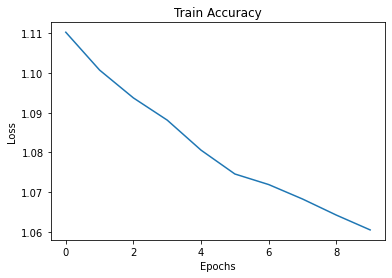

In [32]:
plotGraph(train_loss, 'Train')

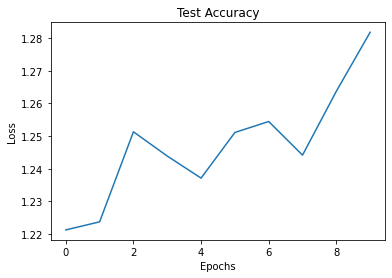

In [33]:
 plotGraph(test_loss, 'Test')

In [34]:
model1 = NeuralNetwork()
model1.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [40]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 1e-2)

In [41]:
train_loss = []
test_loss = []
model1.to(device)
for epoch in range(10):
    print(f"Epoch {epoch+1}\n" , "="*40)
    train_loss.append(train(train_dl, model1, loss, optimizer))
    test_loss.append(test(test_dl, model1, loss))
print('DONE')

Epoch 1
loss : 0.080634  [    0/60000]
loss : 0.465514  [ 6400/60000]
loss : 0.328739  [12800/60000]
loss : 0.393173  [19200/60000]
loss : 0.481067  [25600/60000]
loss : 0.376909  [32000/60000]
loss : 0.385992  [38400/60000]
loss : 0.637141  [44800/60000]
loss : 0.659766  [51200/60000]
loss : 0.456524  [57600/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.454321 

Epoch 2
loss : 0.377662  [    0/60000]
loss : 0.434670  [ 6400/60000]
loss : 0.281736  [12800/60000]
loss : 0.423190  [19200/60000]
loss : 0.449537  [25600/60000]
loss : 0.369247  [32000/60000]
loss : 0.386904  [38400/60000]
loss : 0.608277  [44800/60000]
loss : 0.470742  [51200/60000]
loss : 0.565481  [57600/60000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.425427 

Epoch 3
loss : 0.224294  [    0/60000]
loss : 0.374405  [ 6400/60000]
loss : 0.296183  [12800/60000]
loss : 0.366030  [19200/60000]
loss : 0.488069  [25600/60000]
loss : 0.401121  [32000/60000]
loss : 0.369482  [38400/60000]
loss : 0.576286  [44800/60000]
loss

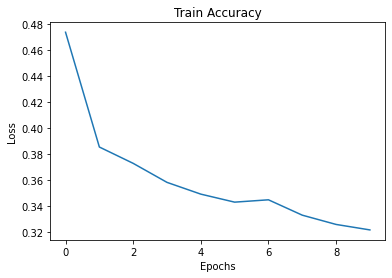

In [42]:
plotGraph(train_loss, 'Train')

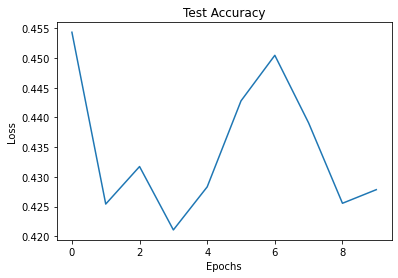

In [43]:
plotGraph(test_loss, 'Test')

In [59]:
learning_rates = [0.1, 0.01, 0.02, 0.03, 0.002]
loss = nn.CrossEntropyLoss()
lr_train_loss = {}
lr_test_loss = {}
for lr in learning_rates:
    optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
    for epoch in range(5):
        print(f"Epoch {epoch+1}\n" , "="*40)
        epoch_train_loss.append(train(train_dl, model1, loss, optimizer))
        epoch_test_loss.append(test(test_dl, model1, loss))
    lr_train_loss[lr] = epoch_train_loss
    lr_test_loss[lr] = epoch_test_loss

Epoch 1
loss : 2.302585  [    0/60000]
loss : 2.302585  [ 6400/60000]
loss : 2.302585  [12800/60000]
loss : 2.302585  [19200/60000]
loss : 2.302585  [25600/60000]
loss : 2.302585  [32000/60000]
loss : 2.302585  [38400/60000]
loss : 2.266607  [44800/60000]
loss : 2.302585  [51200/60000]
loss : 2.302585  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.301813 

Epoch 2
loss : 2.302585  [    0/60000]
loss : 2.302585  [ 6400/60000]
loss : 2.302585  [12800/60000]
loss : 2.302585  [19200/60000]
loss : 2.302585  [25600/60000]
loss : 2.302585  [32000/60000]
loss : 2.302585  [38400/60000]
loss : 2.266607  [44800/60000]
loss : 2.302585  [51200/60000]
loss : 2.302585  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.301813 

Epoch 3
loss : 2.302585  [    0/60000]
loss : 2.302585  [ 6400/60000]
loss : 2.302585  [12800/60000]
loss : 2.302585  [19200/60000]
loss : 2.302585  [25600/60000]
loss : 2.302585  [32000/60000]
loss : 2.302585  [38400/60000]
loss : 2.266607  [44800/60000]
loss

KeyboardInterrupt: 

In [57]:
# train_loss = []
# test_loss = []
# model1.to(device)
# for epoch in range(10):
#     print(f"Epoch {epoch+1}\n" , "="*40)
#     train_loss.append(train(train_dl, model1, loss, optimizer))
#     test_loss.append(test(test_dl, model1, loss))
# print('DONE')
# l = {'cross': nn.CrossEntropyLoss(), 'bce': nn.BCELoss()}
# print(l)
# for e in l:
#     print(l[e])
# nn.BCEWithLogitsLoss()
train(train_dl, model1, nn.CrossEntropyLoss(), optimizer)
test(test_dl, model1, nn.CrossEntropyLoss())

loss : 2.302585  [    0/60000]
loss : 2.302585  [ 6400/60000]
loss : 2.302585  [12800/60000]
loss : 2.302585  [19200/60000]
loss : 2.302585  [25600/60000]
loss : 2.302585  [32000/60000]
loss : 2.302585  [38400/60000]
loss : 2.266607  [44800/60000]
loss : 2.302585  [51200/60000]
loss : 2.302585  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.301813 



2.301813049680868